In [59]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia
import torch
from datasets import *
import torchvision.transforms as transforms
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
from PIL import Image

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-2qks0hwf
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-2qks0hwf
  Created wheel for imgaug: filename=imgaug-0.4.0-py3-none-any.whl size=960986 sha256=2a38ff4129d1f30ad78bfb123f064d5cf2eb6e15942f427de1a7702aa31c58da
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pxq7bkn/wheels/33/b6/f8/c2cd59b6a1f9b6875487d33294c55a4b6a23dfa91088a00950
Successfully built imgaug


In [28]:
dataDir='/data/dataset/coco'
torch.__version__

'1.7.0'

### Adding some helper functions

In [29]:
def getCocoFromAnnotations(annFile):
        coco=COCO(annFile)
        return coco

def showImage(img):
    # load and display image
    # I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    # use url to load image
    # print(img)
    I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()
    
def writeToFile(outdoorImages, dataType):
    filename = f'{dataType}_outdoor'
    print(f'\n Writing OutdoorImageIds to file {filename}')
    file1 = open(f'all_outdoor', 'w+')
    imageName = [img['file_name'] for img in outdoorImages]
    file1.writelines(json.dumps(imageName))

### Outdoor Dataset Generator can be used to get Outdoor Image Ids

In [30]:
class OutdoorDatasetGenerator:
    def __init__(self, coco):
        self.coco = coco
    
    def getCocoCategories(self):
        cats = self.coco.loadCats(self.coco.getCatIds())
        nms=[cat['name'] for cat in cats]
        print(f'There are {len(cats)} coco categories')
        return cats

    def getSuperCategories(self):
        cats = self.getCocoCategories()
        supercats = set([cat['supercategory'] for cat in cats])
        print(f'There are {len(supercats)} coco supercategories')
        # print('COCO supercategories: \n{}'.format(' '.join(nms)))
        return supercats

    def getOutdoorCategories(self):
        cats = self.getCocoCategories()
        outdoorCats = []
        for category in cats:
            if category['supercategory'] == 'outdoor' or category['supercategory'] == 'vehicle':
                outdoorCats.append(category['name'])
        print('Outdoor Categories are', outdoorCats)
        return outdoorCats

    def getOutdoorImageIds(self):
        outdoorCats = self.getOutdoorCategories()
        outdoorImageIds = []
        for cat in outdoorCats:
            catId = self.coco.getCatIds(catNms=[cat])[0];
            images = self.coco.getImgIds(catIds=catId)
            outdoorImageIds.extend(images)
        outdoorImageIds = list(set(outdoorImageIds))
        print(f'Total outdoor images are {len(outdoorImageIds)}')
        return outdoorImageIds
    
    def getImageForCategory(self, cat):
        outdoorCats = self.getOutdoorCategories()
        outdoorImageIds = []
        catId = self.coco.getCatIds(catNms=[cat])[0];
        images = self.coco.getImgIds(catIds=catId)
        return images
    
    def getCategoryForImage(self, imgId):
        outdoorCats = self.getOutdoorCategories()
        outdoorImageIds = []
        for cat in outdoorCats:
            catId = self.coco.getCatIds(catNms=[cat])[0];
            images = self.coco.getImgIds(catIds=catId)
            #outdoorImageIds.extend(images)
            if imgId in images:
                print(cat)
    
    def getImage(self, imgId):
        return self.coco.loadImgs(imgId)[0]

In [31]:
def GetOutdoorImages(dataType, instanceFile):
    print(f'Generating outdoor image dataset for {dataType}\n')
    print('Initialising COCO object for Instances data')
    instanceDataCoco = getCocoFromAnnotations(instanceFile)
    generator = OutdoorDatasetGenerator(instanceDataCoco)
    imageIds =  generator.getOutdoorImageIds()
    images = [generator.getImage(id) for id in imageIds]
    # print(len(images))
    return images

def GetCategoryFromImage(dataType, instanceFile, imgId):
    instanceDataCoco = getCocoFromAnnotations(instanceFile)
    generator = OutdoorDatasetGenerator(instanceDataCoco)
    generator.getCategoryForImage(imgId)

In [32]:
dataType='train2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
trainOutdoorImages = GetOutdoorImages(dataType, instanceFile)

dataType='val2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
valOutdoorImages = GetOutdoorImages(dataType, instanceFile)

# print(len)
# writeToFile(trainOutdoorImages.extend(valOutdoorImages), dataType)

Generating outdoor image dataset for train2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=12.16s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 23686
Generating outdoor image dataset for val2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=4.68s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 11537


##  Getting the dataset for the test set

In [33]:
allImages = trainOutdoorImages+ valOutdoorImages
#writeToFile(allImages, dataType)

print(len(allImages[0:20000]))
print(len(trainOutdoorImages))
print(len(valOutdoorImages))

20000
23686
11537


In [34]:
dataType='val2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
outdoorImages = GetOutdoorImages(dataType, instanceFile)
# writeToFile(outdoorImages, dataType)

Generating outdoor image dataset for val2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=6.14s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 11537


### Captions Viewer can be used to get the captions given an image

In [35]:
class CaptionsViewer:
    def __init__(self, coco):
        self.coco = coco
        
    def showCaptions(self, img):
        annIds = self.coco.getAnnIds(imgIds=img['id']);
        anns = self.coco.loadAnns(annIds)
        # self.coco.showAnns(anns)
        # showImage(img)
        return anns

In [36]:
# dataType='train2017'
dataType='val2017'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
outdoorImages = GetOutdoorImages(dataType, instanceFile)

print('\nGetting random outdoor image')
img = outdoorImages[np.random.randint(0,len(outdoorImages))]

captionsFile='{}/annotations/captions_{}.json'.format(dataDir, dataType)
captionsDataCoco = getCocoFromAnnotations(captionsFile)
print(f'\nCaptions for Image: {img} are\n')
captionsViewer = CaptionsViewer(captionsDataCoco)
print(captionsViewer.showCaptions(img))

Generating outdoor image dataset for val2017

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 1424

Getting random outdoor image
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!

Captions for Image: {'license': 6, 'file_name': '000000153669.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000153669.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-19 19:44:15', 'flickr_url': 'http://farm5.staticflickr.com/4023/4659511777_06fdc54df9_z.jpg', 'id': 153669} are

[{'image_id': 153669, 'id': 508438, 'caption': 'a batter after he has hit a pitched ball before he is going to run'}, {'image_id': 153669, 'id': 511015, 'caption': 'A player i

In [37]:
img = outdoorImages[np.random.randint(0,len(outdoorImages))]
print(img)
captionsViewer = CaptionsViewer(captionsDataCoco)
anns = captionsViewer.showCaptions(img)
print(anns)

{'license': 3, 'file_name': '000000566282.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000566282.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-18 01:52:41', 'flickr_url': 'http://farm8.staticflickr.com/7148/6822486115_2d8d08f045_z.jpg', 'id': 566282}
[{'image_id': 566282, 'id': 726845, 'caption': 'A pair of well dressed men kick a soccer ball on the sidewalk.'}, {'image_id': 566282, 'id': 733301, 'caption': 'Two men kicking a ball on a city street.'}, {'image_id': 566282, 'id': 734411, 'caption': 'A couple of guys are playing ball on a side walk.'}, {'image_id': 566282, 'id': 734456, 'caption': 'A couple of men kicking around a soccer ball.'}, {'image_id': 566282, 'id': 736709, 'caption': 'Two men are kicking a soccer ball on the city sidewalk. '}]


In [38]:
# Calculating if there are any images without any captions
nocaps = 0
for i in outdoorImages:
    anns = captionsViewer.showCaptions(i)
    if(len(anns) == 0):
        nocaps = nocaps+1

print(nocaps)

0


In [39]:
len(outdoorImages)

1424

In [40]:
'''
with open('all_outdoor') as f:
  newImages = json.load(f)

p = 'COCO_val2014_000000216228.jpg'

if p not in newImages:
    print('hello')
    '''

"\nwith open('all_outdoor') as f:\n  newImages = json.load(f)\n\np = 'COCO_val2014_000000216228.jpg'\n\nif p not in newImages:\n    print('hello')\n    "

In [41]:
#len(newImages)

In [42]:
for image in outdoorImages:
    if image['file_name'] == 'COCO_val2014_000000065182.jpg':
        print(image)

In [43]:
print(outdoorImages[0])

{'license': 3, 'file_name': '000000532481.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000532481.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-20 16:28:24', 'flickr_url': 'http://farm7.staticflickr.com/6048/5915494136_da3cfa7c5a_z.jpg', 'id': 532481}


In [44]:
dataType='val2014'
instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
instanceDataCoco = getCocoFromAnnotations(instanceFile)
generator = OutdoorDatasetGenerator(instanceDataCoco)
imageIds =  generator.getImageForCategory('traffic light')
outdoorImageIds = generator.getOutdoorImageIds()
imageIds

loading annotations into memory...
Done (t=5.28s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 11537


[360449,
 221190,
 368648,
 393226,
 253964,
 106508,
 57363,
 565269,
 155671,
 507927,
 270376,
 532530,
 557127,
 393288,
 57415,
 204871,
 204887,
 532568,
 458846,
 532580,
 229478,
 475238,
 475244,
 319607,
 434316,
 8333,
 41119,
 385190,
 319655,
 32941,
 311471,
 106677,
 540860,
 565438,
 205002,
 139468,
 524507,
 499950,
 524533,
 549119,
 581887,
 257,
 90373,
 213255,
 499983,
 24851,
 213276,
 180515,
 246057,
 385346,
 90442,
 254283,
 475484,
 418144,
 359,
 418152,
 328041,
 262505,
 74096,
 344439,
 442746,
 516476,
 565635,
 205190,
 508302,
 205206,
 123289,
 33208,
 172478,
 156098,
 262609,
 270810,
 213475,
 246248,
 573930,
 279024,
 188918,
 90616,
 573947,
 385535,
 295426,
 475660,
 221713,
 565778,
 221737,
 279081,
 492077,
 467511,
 8762,
 221754,
 287291,
 115266,
 361029,
 492102,
 311883,
 533069,
 459342,
 213593,
 516708,
 328316,
 361103,
 213649,
 451228,
 172702,
 434850,
 123555,
 287396,
 246435,
 516775,
 279221,
 699,
 549568,
 336579,
 33489

{'license': 3, 'file_name': 'COCO_val2014_000000156370.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000156370.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 14:06:59', 'flickr_url': 'http://farm8.staticflickr.com/7014/6488659257_da002be495_z.jpg', 'id': 156370}


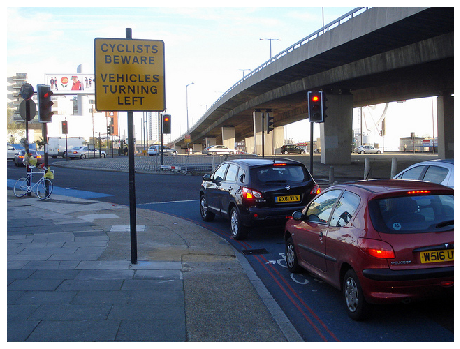

In [45]:
# for imageId in outdoorImages:

image = generator.getImage(156370)
print(image)
showImage(image)


{'license': 3, 'file_name': '000000532481.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000532481.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-20 16:28:24', 'flickr_url': 'http://farm7.staticflickr.com/6048/5915494136_da3cfa7c5a_z.jpg', 'id': 532481}


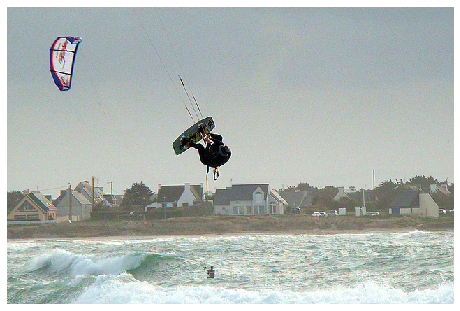

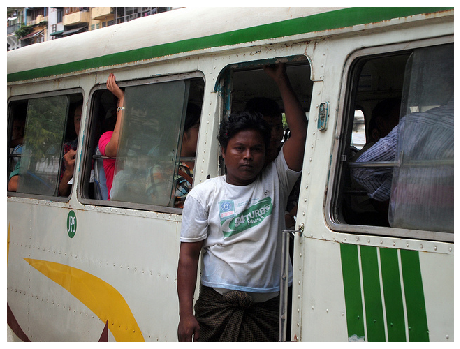

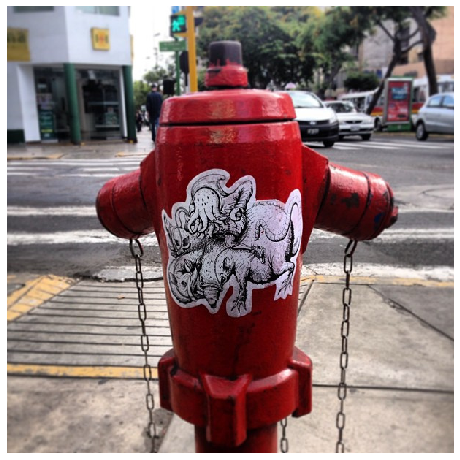

[{'image_id': 532481, 'id': 541125, 'caption': "A person kitesurfing over the waves of the ocean's shore."}, {'image_id': 532481, 'id': 542259, 'caption': 'a kite surfer is doing a flying trick over some water'}, {'image_id': 532481, 'id': 547713, 'caption': 'A man is flying up in the air and having fun. '}, {'image_id': 532481, 'id': 554427, 'caption': 'A guy is waterboarding in the ocean on a windy day.'}, {'image_id': 532481, 'id': 558036, 'caption': 'A person kite boarding in rough seas near the shoreline.'}]
[{'image_id': 319534, 'id': 107375, 'caption': 'A man wearing a t-shirt stands in the door way of a white bus.'}, {'image_id': 319534, 'id': 111722, 'caption': 'A man in a white tee shirt standing in the door of a bus.'}, {'image_id': 319534, 'id': 118961, 'caption': 'A person standing in the doorway of a mass transit vehicle.'}, {'image_id': 319534, 'id': 120023, 'caption': 'A young man standing in the doorway of a bus'}, {'image_id': 319534, 'id': 120896, 'caption': 'A boy s

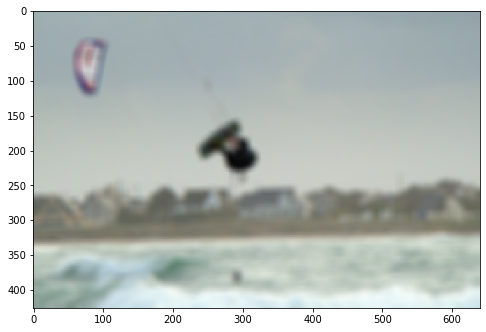

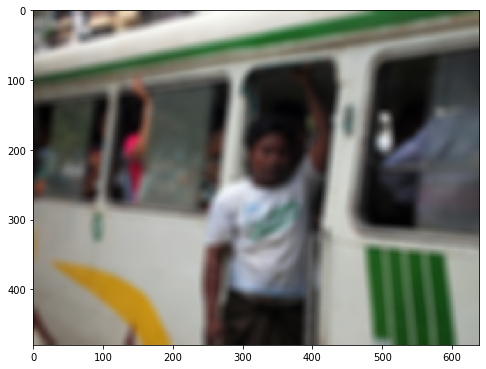

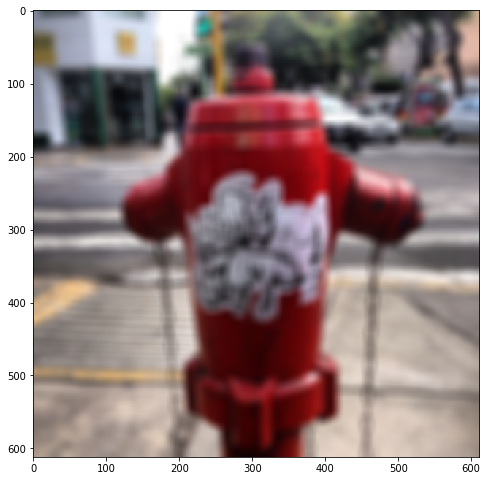

In [46]:
image2 = outdoorImages[0]
print(image2)
showImage(image2)

image3 = outdoorImages[9]
showImage(image3)

image4 = outdoorImages[15]
showImage(image4)

captionsViewer = CaptionsViewer(captionsDataCoco)
anns = captionsViewer.showCaptions(image2)
print(anns)
anns = captionsViewer.showCaptions(image3)
print(anns)
anns = captionsViewer.showCaptions(image4)
print(anns)

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(6.0, 8.0)) # blur images with a sigma of 0 to 3.0
])

image_aug = seq(images=[io.imread(image2['coco_url']), io.imread(image3['coco_url']), io.imread(image4['coco_url'])])
#images=[io.imread(image2['coco_url']), io.imread(image3['coco_url'])]


for i in image_aug:
    #plt.axis('off')
    plt.imshow(i)
    plt.show()


{'license': 3, 'file_name': '000000532481.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000532481.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-20 16:28:24', 'flickr_url': 'http://farm7.staticflickr.com/6048/5915494136_da3cfa7c5a_z.jpg', 'id': 532481}


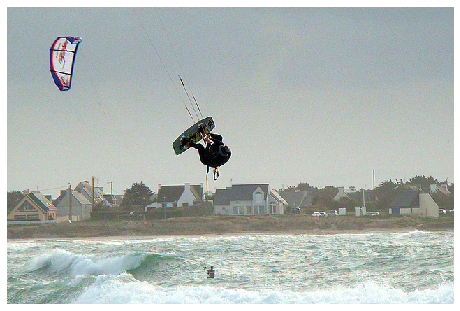

[{'image_id': 532481, 'id': 541125, 'caption': "A person kitesurfing over the waves of the ocean's shore."}, {'image_id': 532481, 'id': 542259, 'caption': 'a kite surfer is doing a flying trick over some water'}, {'image_id': 532481, 'id': 547713, 'caption': 'A man is flying up in the air and having fun. '}, {'image_id': 532481, 'id': 554427, 'caption': 'A guy is waterboarding in the ocean on a windy day.'}, {'image_id': 532481, 'id': 558036, 'caption': 'A person kite boarding in rough seas near the shoreline.'}]


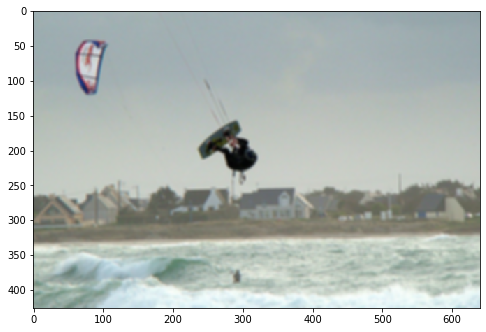

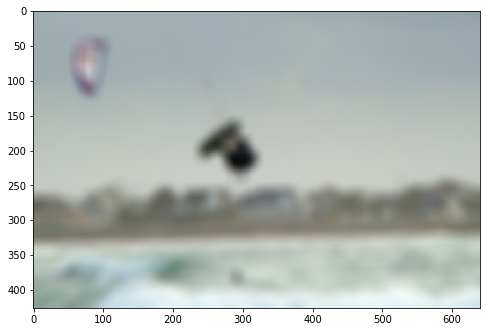

In [71]:
#test set: (0,2), (2,4), (4,6), (6,8), (8,10), (10,12) --> beyond 12 is probably too much
#can stop at 9
#sigma = amount of blurring
image2 = outdoorImages[0]
print(image2)
showImage(image2)

#image3 = outdoorImages[9]
#showImage(image3)

#image4 = outdoorImages[15]
#showImage(image4)

captionsViewer = CaptionsViewer(captionsDataCoco)
anns = captionsViewer.showCaptions(image2)
print(anns)
#anns = captionsViewer.showCaptions(image3)
#print(anns)
#anns = captionsViewer.showCaptions(image4)
#print(anns)

seq1 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(2.0, 2.0)) # blur images with a sigma of 0 to 3.0
])

seq2 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(9.0, 9.0)) # blur images with a sigma of 0 to 3.0
])

image_aug1 = seq1(images=[io.imread(image2['coco_url'])])
image_aug2 = seq2(images=[io.imread(image2['coco_url'])])

#images=[io.imread(image2['coco_url']), io.imread(image3['coco_url'])]


for i in image_aug1+image_aug2:
    #plt.axis('off')
    plt.imshow(i)
    plt.show()

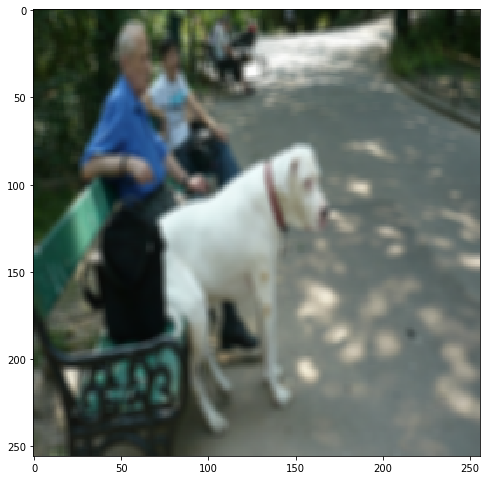

In [82]:
torch.manual_seed(17)

data_folder = '../outdoor_output_full'  # folder with data files saved by create_input_files.py
data_name = 'coco_5_cap_per_img_5_min_word_freq'  # base name shared by data files
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

#dataset = CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize, transforms.GaussianBlur(5,sigma=(0.001,3))]))
dataset = CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([transforms.GaussianBlur(5, sigma=(9, 9))]))
#dataset = CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([transforms.Lambda(lambda x: seq1(x)),
#                                                                                       transforms.ToTensor()]))
#dataset = CaptionDataset(data_folder, data_name, 'TEST', transform=None)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

img, caption, caplen, all_captions = dataset.__getitem__(10)
trans = transforms.ToPILImage()
plt.imshow(trans(img).convert("RGB"))

#print(img)
k = 0
while k < 5:
    for i, (image, caps, caplens, allcaps) in enumerate(test_loader):
        #to_pil = transforms.ToPILImage()
        #img = to_pil(image)
        #I=io.imread(image)
        #plt.imshow(I)
        
        k+=1
        if k == 5:
            break